Day 4 — Construct and Analyze Additional Benchmarks

Today’s goal:

1. Define 3-5 alternative benchmark structures using long-history ETFs.

2. Download and prepare 15-year price history for all associated ETFs.

3. Compute cumulative returns for each benchmark.

4. Compute annualized returns over the full period.

5. Compute annualized returns for each calendar year.

6. Visualize performance compared to the portfolio and original benchmark.

Introduction: In Day 4, we extend our analysis by constructing several alternative benchmarks that represent different investment philosophies:

- U.S.-only

- Developed ex-US

- Aggressive (lower bond weight)

Each benchmark will be defined using ETFs with 15+ years of reliable historical data so that long-term performance can be measured cleanly.

We will follow the same workflow as Days 1–3:

- define benchmark tickers + weights

- fetch price data

- compute returns

- compare risk/return outcomes

In [1]:
# Imports
# Day 4 — Additional Benchmarks

import pandas as pd
import numpy as np
import yfinance as yf
import json
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

data_dir = Path("..") / "data"

In [2]:
# Define additional benchmarks
# Each benchmark has:
#   - "tickers": list of ETF tickers
#   - "weights": dict of weights (will normalize just in case)

benchmarks = {
    "us": {
        "description": "U.S.-only assets benchmark",
        "tickers": ["VTI", "BND"],
        "weights": {
            "VTI": 0.88,  # U.S. total equity market
            "BND": 0.12,  # U.S. total bond market
        },
    },
    "developed_ex_us": {
        "description": "Ex-U.S. developed markets benchmark",
        "tickers": ["VEA", "IGOV"],
        "weights": {
            "VEA": 0.88,  # Ex-U.S. developed markets equity
            "IGOV": 0.12,  # Ex-U.S. bonds
        },
    },
    "us_aggressive": {
        "description": "US-only assets, more aggressive (lower bond weight)",
        "tickers": ["VTI", "BND"],
        "weights": {
            "VTI": 0.92,
            "BND": 0.08
        },
    },
}

# Normalize weights for safety (so each benchmark sums exactly to 1)
for name, spec in benchmarks.items():
    w = spec["weights"]
    total = sum(w.values())
    spec["weights"] = {k: v / total for k, v in w.items()}

In [3]:
# Collect all unique ETF tickers used across benchmarks
all_tickers = sorted({t for spec in benchmarks.values() for t in spec["tickers"]})
all_tickers

['BND', 'IGOV', 'VEA', 'VTI']

In [5]:
def get_fund_name(ticker):
    try:
        info = yf.Ticker(ticker).info
        return info.get("longName") or info.get("shortName") or ticker
    except:
        return ticker

In [6]:
new_benchmark_names = {}

for name, spec in benchmarks.items():
    tickers = spec["tickers"]
    new_benchmark_names[name] = {t: get_fund_name(t) for t in tickers}

new_benchmark_names

{'us': {'VTI': 'Vanguard Total Stock Market Index Fund ETF Shares',
  'BND': 'Vanguard Total Bond Market Index Fund'},
 'developed_ex_us': {'VEA': 'Vanguard FTSE Developed Markets Index Fund ETF Shares',
  'IGOV': 'iShares International Treasury Bond ETF'},
 'us_aggressive': {'VTI': 'Vanguard Total Stock Market Index Fund ETF Shares',
  'BND': 'Vanguard Total Bond Market Index Fund'}}

In [7]:
from datetime import date
from dateutil.relativedelta import relativedelta

def get_price_data(tickers):
    """
    Download 15 years of daily Close prices ending today.
    Returns a clean DataFrame (ffill/bfill, sorted index).
    """
    end = date.today()
    start = end - relativedelta(years=15)

    data = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        progress=False
    )

    # Extract Close price (handle MultiIndex vs single-level)
    if isinstance(data.columns, pd.MultiIndex):
        prices = data["Close"]
    else:
        prices = data[["Close"]]
        prices.columns = tickers

    return prices.sort_index().ffill().bfill()


# --- Use the consolidated function for Day 4 tickers ---
etf_prices = get_price_data(all_tickers)
etf_prices.head()


C:\Users\agbro\AppData\Local\Temp\ipykernel_30696\1135474413.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Ticker,BND,IGOV,VEA,VTI
Date,,,,
2010-11-15,52.877560,46.206200,22.665838,47.233906
2010-11-16,53.052895,45.730915,22.097147,46.482327
2010-11-17,53.065872,45.793091,22.228378,46.559006
2010-11-18,53.065872,45.815311,22.778315,47.210884
2010-11-19,53.078838,46.135113,22.790812,47.402607


In [8]:
# ETF daily returns
etf_returns = etf_prices.pct_change().dropna()
etf_returns.head()

Ticker,BND,IGOV,VEA,VTI
Date,,,,
2010-11-16,0.003316,-0.010286,-0.025090,-0.015912
2010-11-17,0.000245,0.001360,0.005939,0.001650
2010-11-18,0.000000,0.000485,0.024740,0.014001
2010-11-19,0.000244,0.006980,0.000549,0.004061
2010-11-22,0.002936,-0.002022,-0.010694,0.000162


In [9]:
# Load original benchmark & portfolio price data

benchmark_prices = pd.read_parquet(data_dir / "benchmark_prices.parquet")
portfolio_prices = pd.read_parquet(data_dir / "portfolio_prices.parquet")

with open(data_dir / "benchmark_weights.json") as f:
    benchmark_weights = json.load(f)

with open(data_dir / "portfolio_weights.json") as f:
    portfolio_weights = json.load(f)

# Daily returns
benchmark_returns = benchmark_prices.pct_change().dropna()
portfolio_returns = portfolio_prices.pct_change().dropna()

# Align benchmark & portfolio date index
common_bp_index = benchmark_returns.index.intersection(portfolio_returns.index)
benchmark_returns = benchmark_returns.loc[common_bp_index]
portfolio_returns = portfolio_returns.loc[common_bp_index]

In [10]:
# Compute weighted daily returns for original benchmark & portfolio

bw = pd.Series(benchmark_weights)
pw = pd.Series(portfolio_weights)

orig_benchmark_total = (benchmark_returns * bw).sum(axis=1)
portfolio_total = (portfolio_returns * pw).sum(axis=1)

orig_benchmark_total.name = "original_benchmark"
portfolio_total.name = "portfolio"

In [11]:
# Compute weighted daily returns for each additional benchmark

benchmark_ret_dict = {}

for name, spec in benchmarks.items():
    tickers = spec["tickers"]
    w = pd.Series(spec["weights"])
    
    # Only use tickers that we actually have returns for
    tickers = [t for t in tickers if t in etf_returns.columns]
    rets = etf_returns[tickers]
    
    benchmark_ret_dict[name] = (rets * w).sum(axis=1)

additional_benchmark_returns = pd.DataFrame(benchmark_ret_dict)
additional_benchmark_returns.head()

,us,developed_ex_us,us_aggressive
Date,,,
2010-11-16,-0.013605,-0.023314,-0.014374
2010-11-17,0.001481,0.005389,0.001537
2010-11-18,0.012321,0.021830,0.012881
2010-11-19,0.003603,0.001320,0.003756
2010-11-22,0.000495,-0.009653,0.000384


In [12]:
# Align all return series on common date range

all_returns = pd.concat(
    [
        portfolio_total,
        orig_benchmark_total,
        additional_benchmark_returns,
    ],
    axis=1
).dropna()

all_returns.head()

,portfolio,original_benchmark,us,developed_ex_us,us_aggressive
Date,,,,,
2010-11-16,-0.014593,-0.017825,-0.013605,-0.023314,-0.014374
2010-11-17,0.001961,0.002489,0.001481,0.005389,0.001537
2010-11-18,0.014337,0.017952,0.012321,0.021830,0.012881
2010-11-19,0.002755,0.000000,0.003603,0.001320,0.003756
2010-11-22,0.000580,-0.003181,0.000495,-0.009653,0.000384


In [13]:
# Cumulative returns for each series (growth of $1)

cum_returns = (1 + all_returns).cumprod()
cum_returns.head()

,portfolio,original_benchmark,us,developed_ex_us,us_aggressive
Date,,,,,
2010-11-16,0.985407,0.982175,0.986395,0.976686,0.985626
2010-11-17,0.987339,0.984620,0.987856,0.981950,0.987142
2010-11-18,1.001494,1.002295,1.000028,1.003386,0.999857
2010-11-19,1.004254,1.002295,1.003631,1.004710,1.003612
2010-11-22,1.004837,0.999107,1.004127,0.995012,1.003997


In [14]:
# Full-period annualized returns for each series

ann_factor = 252
n_days = len(all_returns)

total_return = (1 + all_returns).prod() - 1
annualized_return = (1 + total_return) ** (ann_factor / n_days) - 1
annualized_return.to_frame(name="Annualized Return")

,Annualized Return
portfolio,0.132421
original_benchmark,0.090777
us,0.126011
developed_ex_us,0.061156
us_aggressive,0.130256


In [15]:
# Calendar-year returns (geometric) for each series

def annualize_series(series: pd.Series) -> float:
    return (1 + series).prod() - 1

yearly_returns = all_returns.groupby(all_returns.index.year).apply(
    lambda df: (1 + df).prod() - 1
)

yearly_returns

,portfolio,original_benchmark,us,developed_ex_us,us_aggressive
Date,,,,,
2010,0.051463,0.034384,0.052069,0.017532,0.054667
2011,0.018551,-0.062859,0.021567,-0.104358,0.017706
2012,0.178750,0.150600,0.148680,0.170298,0.153972
2013,0.300996,0.200233,0.286718,0.188829,0.302480
2014,0.103166,0.032987,0.118162,-0.054301,0.120630
2015,0.023440,-0.015168,0.005265,-0.010154,0.004738
2016,0.121553,0.075744,0.116530,0.026127,0.120437
2017,0.237121,0.212971,0.190488,0.245709,0.197674
2018,-0.031991,-0.083930,-0.044545,-0.132800,-0.047106


In [16]:
# Basic risk metrics: annualized vol & Sharpe (RF = 0)

annualized_vol = all_returns.std() * np.sqrt(ann_factor)
sharpe_ratio = annualized_return / annualized_vol

risk_table = pd.DataFrame(
    {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe (RF=0)": sharpe_ratio,
    }
).T

risk_table

,portfolio,original_benchmark,us,developed_ex_us,us_aggressive
Annualized Return,0.132421,0.090777,0.126011,0.061156,0.130256
Annualized Volatility,0.151277,0.152194,0.154723,0.161701,0.161617
Sharpe (RF=0),0.875356,0.596456,0.814433,0.378207,0.805955


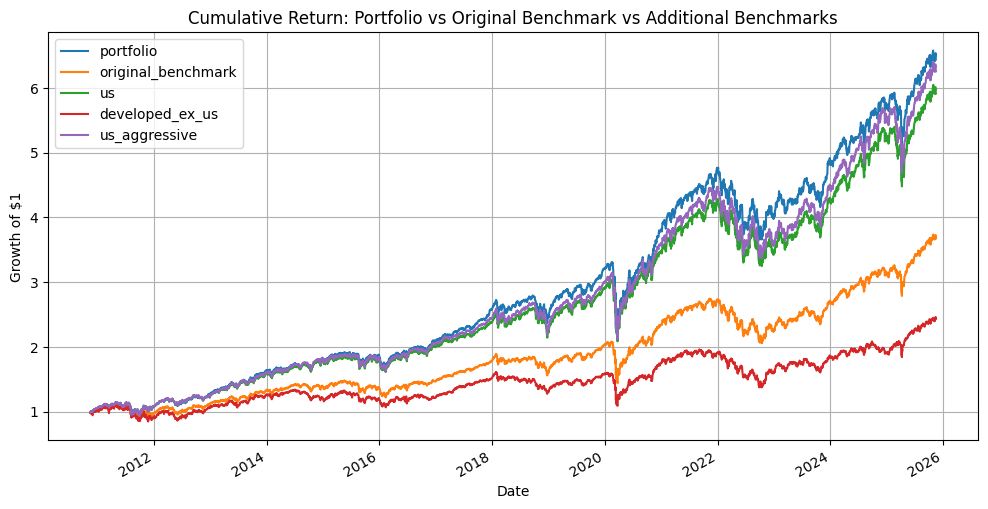

In [17]:
# Plot cumulative return comparison (Goal: visualize step 2)

ax = cum_returns.plot(figsize=(12, 6))
ax.set_title("Cumulative Return: Portfolio vs Original Benchmark vs Additional Benchmarks")
ax.set_ylabel("Growth of $1")
plt.legend()
plt.show()

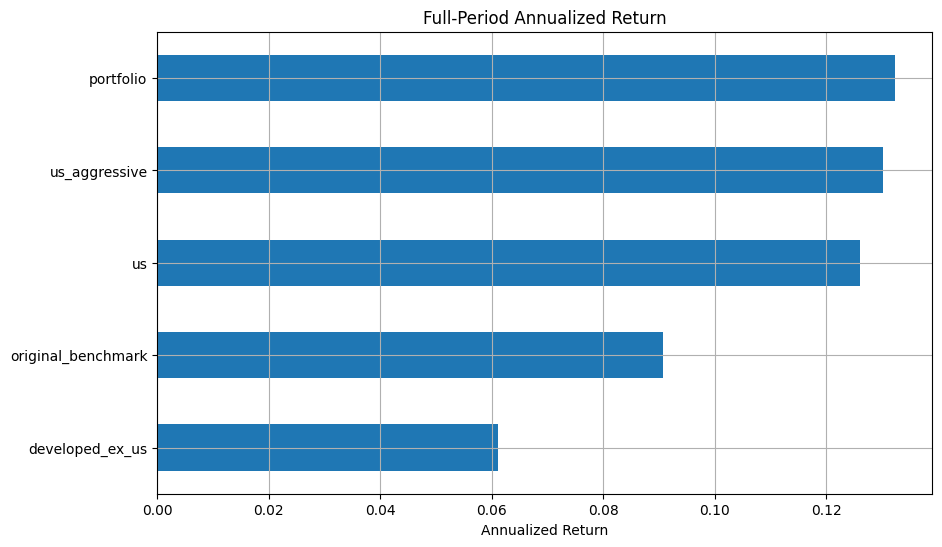

In [18]:
# Full-period annualized return comparison (Goal: visualize step 4)

ax = annualized_return.sort_values().plot(kind="barh", figsize=(10, 6))
ax.set_title("Full-Period Annualized Return")
ax.set_xlabel("Annualized Return")
plt.show()

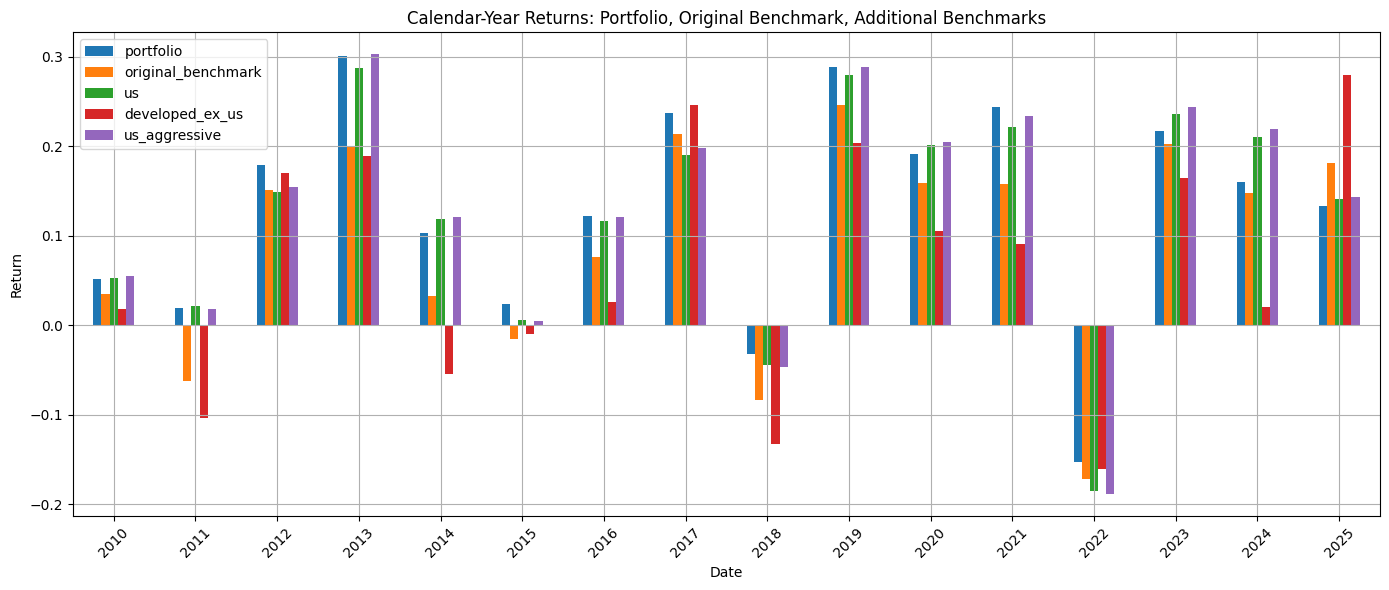

In [19]:
# Calendar-year returns (Goal: visualize step 3)

ax = yearly_returns.plot(kind="bar", figsize=(14, 6))
ax.set_title("Calendar-Year Returns: Portfolio, Original Benchmark, Additional Benchmarks")
ax.set_ylabel("Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()